In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.util import pr
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
stemmer = nltk.SnowballStemmer("english")
nltk.download('stopwords')
stopword=set(stopwords.words('english'))
from textblob import TextBlob
from wordcloud import WordCloud,STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
maxTweets = 300
tweets_list_new = []

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('ViktoriaPlzenQarabag since:2022-08-23 until:2022-08-24').get_items()):
    if i>maxTweets:
        break
    tweets_list_new.append([tweet.date, tweet.id, tweet.content, tweet.username])

In [3]:
df = pd.DataFrame(tweets_list_new, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])
df.head()

,Datetime,Tweet Id,Text,Username
0,2022-08-23 23:03:46+00:00,1562214039824076800,#UEFA #ChampionsLeague #UCLDraw #UCL #Viktoria...,carlito61806928
1,2022-08-23 21:09:50+00:00,1562185368472064001,"#ViktoriaPlzenQarabag 2-1, gli highlights\nhtt...",sportface2016
2,2022-08-23 21:01:57+00:00,1562183384322957312,Kouzelník na plac !\n\n#ViktoriaPlzenQarabag \...,Jendys_
3,2022-08-23 21:00:21+00:00,1562182983074955264,#ViktoriaPlzen turned the #playoff match vs #q...,romanbe80764216
4,2022-08-23 20:58:36+00:00,1562182539812511745,"Şahruddin qapını qoyub çörək 🍞 almağa gedirdi,...",mubarakgraphs


In [4]:
#Export dataframe into a CSV
df.to_csv('tweets_uel.csv', sep=',', index=False)

In [5]:
df.Text

0     #UEFA #ChampionsLeague #UCLDraw #UCL #Viktoria...
1     #ViktoriaPlzenQarabag 2-1, gli highlights\nhtt...
2     Kouzelník na plac !\n\n#ViktoriaPlzenQarabag \...
3     #ViktoriaPlzen turned the #playoff match vs #q...
4     Şahruddin qapını qoyub çörək 🍞 almağa gedirdi,...
5     🇨🇿 Viktoria Plzen Czeched themselves into the ...
6     FT: #ViktoriaPlzenQarabag 2️⃣-1️⃣\n\n #UCL htt...
7     ⏱ | TERMINÉ ! \n\nLe FC Viktoria se qualifie e...
8     Viktoria Plzeň je počtvrté v historii ve skupi...
9     Viktoria Plzen take the lead due to the opport...
10    Absolute chaos for Qarabag as Jan Kopic, the s...
11    Goaaaalll #uclplayoff\n\n#ViktoriaPlzenQarabag...
12    46' | 0-1 | The second half begins. #UCL\n\n#V...
13        #ViktoriaPlzenQarabag https://t.co/muLr2z2vbV
14    Qarabağımızın ilk qolu !!!#UCL #ViktoriaPlzenQ...
15    Watch Viktoria Plzen vs Qarabag Live Streaming...
16    HT: #ViktoriaPlzenQarabag 0️⃣-1️⃣\n\n#UCL http...
17    Ozobic scores a beauty of a volley to surp

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Datetime  27 non-null     datetime64[ns, UTC]
 1   Tweet Id  27 non-null     int64              
 2   Text      27 non-null     object             
 3   Username  27 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 992.0+ bytes


In [7]:
def hashtag_extract(text_list):
    hashtags = []
  
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)
    return hashtags
def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
    'Count': list(a.values())})
    
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()

In [8]:
hashtags = hashtag_extract(df["Text"])
hashtags = sum(hashtags, [])

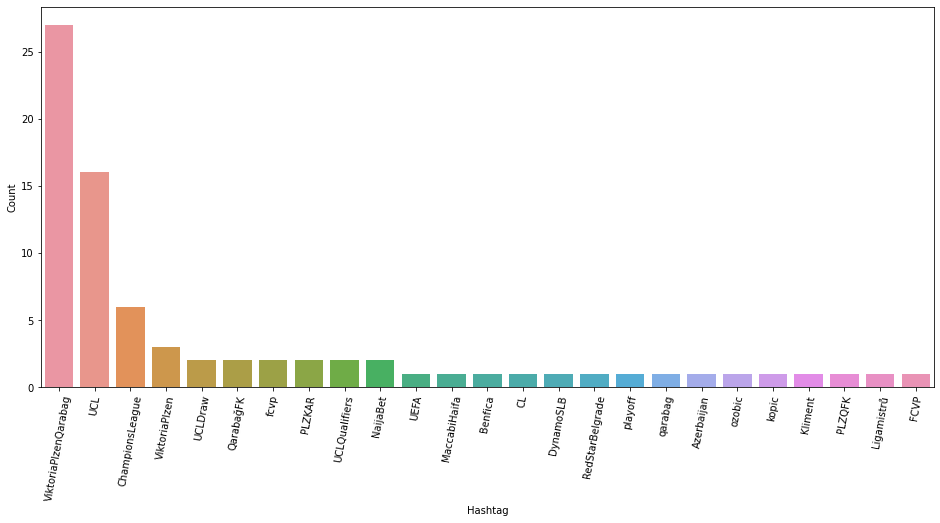

In [9]:
generate_hashtag_freqdist(hashtags)

In [10]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
df["Text"] = df["Text"].apply(clean)

In [11]:
def analyze_sentiment(tweet):
    analysis = TextBlob(clean(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [12]:
df['Sentiment'] = df['Text'].apply(lambda x:analyze_sentiment(x))
df['Length'] = df['Text'].apply(len)
df['Word_counts'] = df['Text'].apply(lambda x:len(str(x).split()))

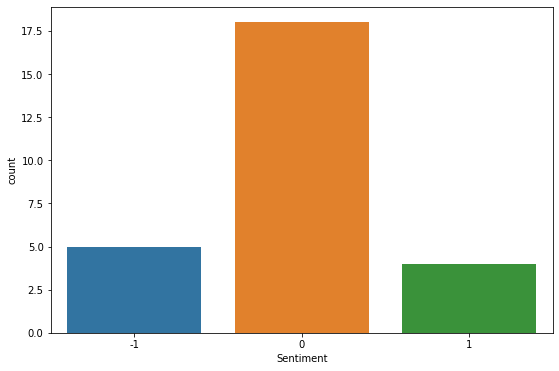

In [13]:
plt.figure(figsize = (9,6))
sns.countplot(data = df, x = 'Sentiment')
plt.show()

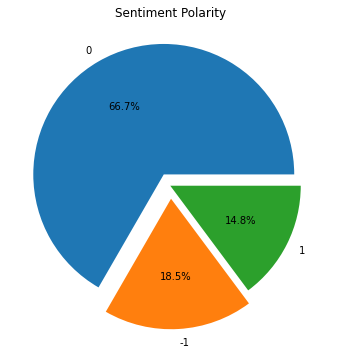

In [14]:
fig, ax = plt.subplots(figsize = (8, 6))
sizes = [count for count in df['Sentiment'].value_counts()]
labels = list(df['Sentiment'].value_counts().index)
explode = (0.1, 0.1, 0)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode)
ax.set_title('Sentiment Polarity')
plt.show()

In [15]:
neutral = df[df['Sentiment'] == 0]
positive = df[df['Sentiment'] == 1]
negative = df[df['Sentiment'] == -1]

In [16]:
stop_word=['le','ht','rt','se','la','en','sa','del','de','fk','ft','fc','je','el','v']

In [17]:
stop_w=STOPWORDS

In [18]:
stop_w=stop_w.update(stop_word)

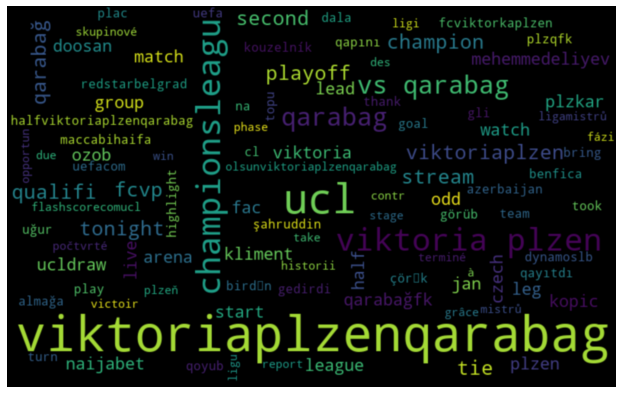

In [19]:
txt = ' '.join(text for text in df['Text'])
wordcloud = WordCloud(
background_color = 'black',
max_font_size = 100,
max_words = 100,
width = 800,
height = 500,stopwords=stop_w
).generate(txt)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud,interpolation = 'bicubic')
plt.axis('off')
plt.show()
#wordcloud.to_image()
#wordcloud.to_file("words.png")

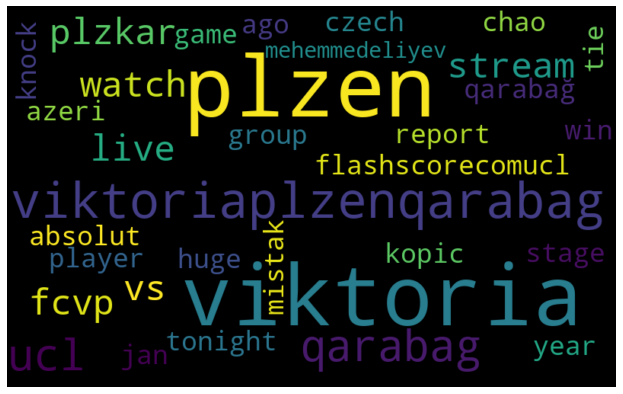

In [20]:
positive_words =' '.join([text for text in df['Text'][df['Sentiment'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,stopwords=stop_w).generate(positive_words)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
#wordcloud.to_image()
#wordcloud.to_file("positive.png")

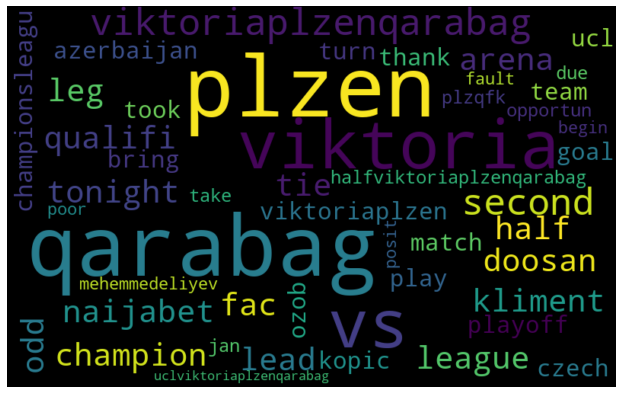

In [21]:
negative_words =' '.join([text for text in df['Text'][df['Sentiment'] == -1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,stopwords=stop_w).generate(negative_words)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
#wordcloud.to_image()
#wordcloud.to_file("negative.png")

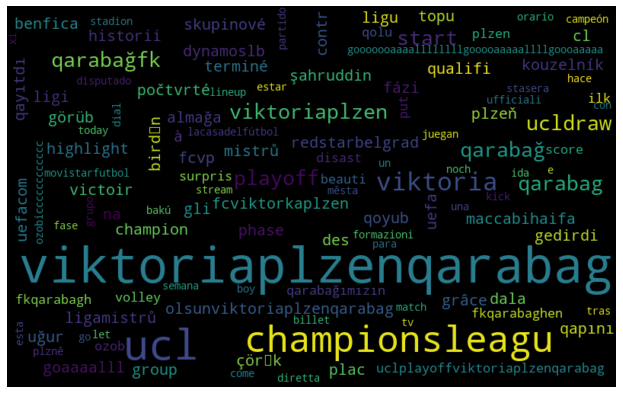

In [22]:
neutral_words =' '.join([text for text in df['Text'][df['Sentiment'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,stopwords=stop_w).generate(neutral_words)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
#wordcloud.to_image()
#wordcloud.to_file("neutral.png")